In [151]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import time
from PIL import Image
import requests


Ze względu na wielkie problemy z pytorchem i pytrochem lightniningiem, zdecydowałem się zrobić tego laba przy pomocy tensorflow i keras.  
Problemy miałem następujące:
- dataloader bardzo bardzo spowalniał, jeśli zwiększałem liczbę workerów (nie jest to wielki problem)
- Mój model, który moim zdaniem jest dobrze zdefiniowany, (nie wykluczam, że się pomyliłem ale porówynywałem do bardzo wielu innych modeli w internecie), bardzo słabo się uczył
- Obie kwestie nie gwarantują błędów po stronie pytorcha, ale biorąc pod uwagę dosyć specyficzną maszynę na której pracuję i liczbę problemów jaką znalazłem wolałem zmienic framework - potencjalnie będę próbował wrócić do pytorch lightning, ale nie mam teraz czasu szukać problemów 

In [2]:
cifar10 = tf.keras.datasets.cifar10
(train_images, train_labels), (val_images, val_labels) = cifar10.load_data()
info = tfds.builder('cifar10').info
info

2022-10-27 11:10:12.223962: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


tfds.core.DatasetInfo(
    name='cifar10',
    full_name='cifar10/3.0.2',
    description="""
    The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.
    """,
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    data_path='/var/folders/8p/_cz7tfws6qj3stcp8jwc282r0000gn/T/tmpts2uasditfds',
    file_format=tfrecord,
    download_size=162.17 MiB,
    dataset_size=132.40 MiB,
    features=FeaturesDict({
        'id': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=50000, num_shards=1>,
    },
    citation="""@TECHREPORT{Krizhevsky09learningmultiple,
        author = {Alex K

In [3]:
classes = info.features['label'].names
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [4]:
print(train_images.shape, train_labels.shape, val_images.shape, val_labels.shape)

(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


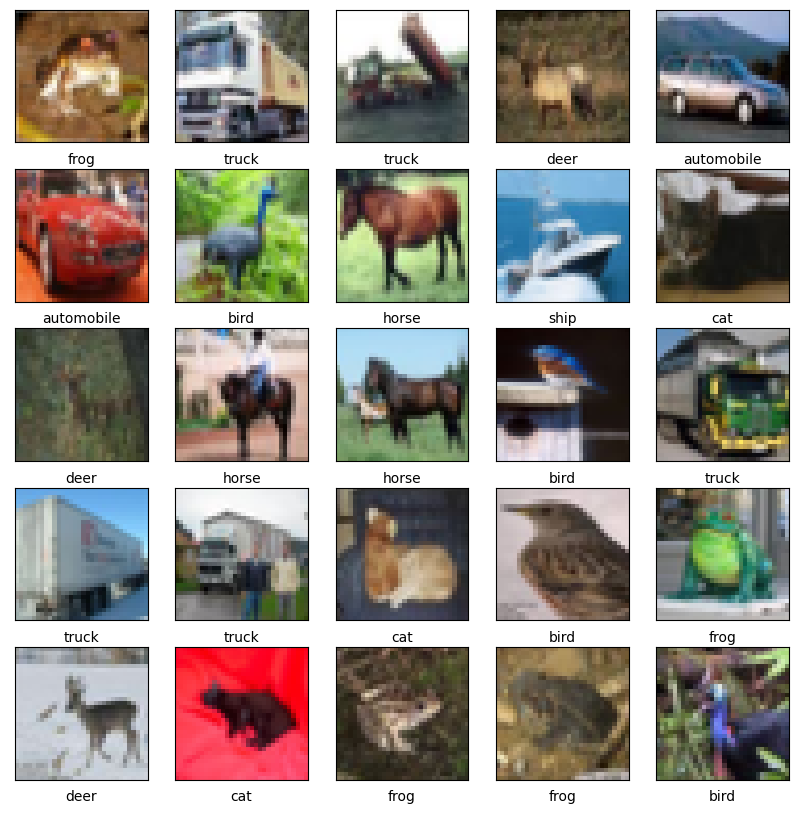

In [5]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    plt.xlabel(classes[train_labels[i][0]])
plt.show()

Bardzo różnorodne zdjęcia.

In [6]:
train_labels = tf.one_hot(tf.reshape(train_labels, train_labels.shape[0]), depth=10)
val_labels = tf.one_hot(tf.reshape(val_labels, val_labels.shape[0]), depth=10)
train_images = train_images / 255.0
val_images = val_images / 255.0
train_images[0].shape

Metal device set to: Apple M1 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2022-10-27 11:10:15.855739: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-27 11:10:15.855866: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


(32, 32, 3)

Wykorzystałem funkcję tf.one_hot do zmiany kodowania labeli na one hot encoding.  
Dodatkowo normalizuję zbiory danych.

In [7]:
minmodel = tf.keras.Sequential([
    tf.keras.layers.Conv2D(5, 3, padding='same', activation='sigmoid', input_shape=train_images[0].shape),
    tf.keras.layers.Conv2D(5, 3, padding='same', activation='sigmoid'),
    tf.keras.layers.MaxPool2D(pool_size=(8,8), padding='valid'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=10, activation='softmax')
])

In [8]:
minmodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 5)         140       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 5)         230       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 4, 4, 5)          0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 80)                0         
                                                                 
 dense (Dense)               (None, 10)                810       
                                                                 
Total params: 1,180
Trainable params: 1,180
Non-trainable params: 0
______________________________________________________

Do implementacji minimalnej architektury wykorzystałem, tf.keras.Sequential - który gwarantuje nam sekwencyjne działanie zdefiniowanych warstw, oraz warst - Conv2D dwa razy, MaxPooling2D, Flatten, Dense.  
Zgodnie z poleceniem zadania.  
Taki model ma 1180 parametrów.  


In [10]:
first10 = minmodel(train_images[:10])
print(tf.math.reduce_all(tf.one_hot(tf.math.argmax(first10, axis=1), depth=10)==train_labels[:10], 1), '\n', tf.math.argmax(first10, axis=1))
print(tf.math.reduce_max(first10, axis=1))

tf.Tensor([False  True  True False False False False False False False], shape=(10,), dtype=bool) 
 tf.Tensor([9 9 9 9 9 9 9 9 9 9], shape=(10,), dtype=int64)


Jak widać model daje bardzo słabe wyniki, ma bardzo duży bias do jednej(czasem kilku konkretrnych) klasy.

In [11]:
minmodel.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

In [12]:
start_time=time.time()
minhistory = minmodel.fit(
    x=train_images,
    y=train_labels,
    batch_size=64,
    epochs=150,
    verbose=1,
    validation_data=(val_images, val_labels)
)
print(f"time: {time.time()-start_time}")

Epoch 1/150


2022-10-27 11:10:22.840351: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-10-27 11:10:23.076174: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


780/782 [============================>.] - ETA: 0s - loss: 2.3099 - accuracy: 0.1015

2022-10-27 11:10:33.350608: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


782/782 [==============================] - 11s 14ms/step - loss: 2.3099 - accuracy: 0.1014 - val_loss: 2.3022 - val_accuracy: 0.0999
Epoch 2/150
782/782 [==============================] - 10s 13ms/step - loss: 2.3018 - accuracy: 0.1057 - val_loss: 2.3015 - val_accuracy: 0.1062
Epoch 3/150
782/782 [==============================] - 10s 13ms/step - loss: 2.3006 - accuracy: 0.1091 - val_loss: 2.2996 - val_accuracy: 0.1402
Epoch 4/150
782/782 [==============================] - 10s 13ms/step - loss: 2.2987 - accuracy: 0.1183 - val_loss: 2.2978 - val_accuracy: 0.1433
Epoch 5/150
782/782 [==============================] - 10s 13ms/step - loss: 2.2966 - accuracy: 0.1284 - val_loss: 2.2950 - val_accuracy: 0.1022
Epoch 6/150
782/782 [==============================] - 10s 13ms/step - loss: 2.2929 - accuracy: 0.1408 - val_loss: 2.2899 - val_accuracy: 0.1665
Epoch 7/150
782/782 [==============================] - 10s 13ms/step - loss: 2.2865 - accuracy: 0.1493 - val_loss: 2.2819 - val_accuracy: 0.16

Model liczy mniej więcej 30 min.  
Trochę mniej jak nie korzystam z komputera, trochę więcej jeśli np. słucham wykładu.

In [18]:
minhistory.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

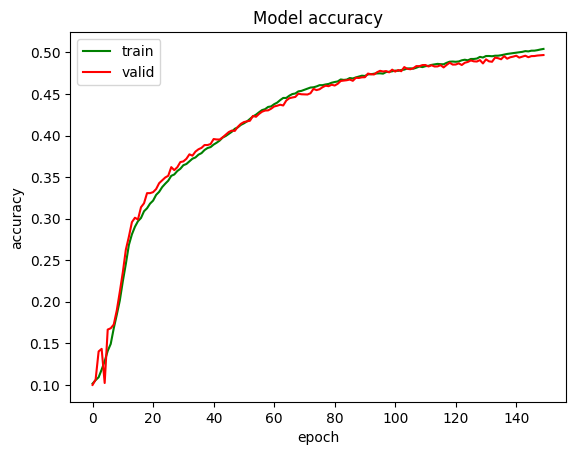

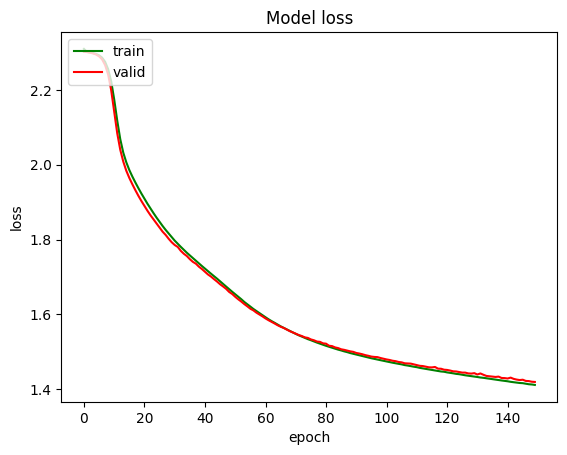

In [20]:
def print_train_and_val(history, gtype):
    plt.plot(history[gtype], 'g')
    plt.plot(history['val_'+gtype], 'r')
    plt.title('Model '+gtype)
    plt.ylabel(gtype)
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()

def print_history(history):
    print_train_and_val(history, 'accuracy')
    print_train_and_val(history, 'loss')

print_history(minhistory.history)

In [30]:
first10 = minmodel(train_images[:10])
print(tf.math.reduce_all(tf.one_hot(tf.math.argmax(first10, axis=1), depth=10)==train_labels[:10], 1), '\n', tf.math.argmax(first10, axis=1))
print(tf.math.reduce_max(first10, axis=1))

tf.Tensor([False  True  True False  True False False  True  True False], shape=(10,), dtype=bool) 
 tf.Tensor([7 9 9 6 1 7 7 7 8 7], shape=(10,), dtype=int64)
tf.Tensor(
[0.28862807 0.52612484 0.197822   0.41355667 0.37701195 0.28073245
 0.50594556 0.3302498  0.7759927  0.25490594], shape=(10,), dtype=float32)


Jak widać, po uczeniu, nasz model znacznie lepiej rozpoznaje klasy, choć dalej nieperfekcyjnie i wciąż możemy zaobserwować pewne biasy co do niektórych klas.  
Widać, że często przy pomyłkach, pewność modelu est stosunkowo niska.

In [32]:
minmodel2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(20, 3, padding='same', activation='sigmoid', input_shape=train_images[0].shape),
    tf.keras.layers.Conv2D(20, 3, padding='same', activation='sigmoid'),
    tf.keras.layers.MaxPool2D(pool_size=(8,8), padding='valid'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=10, activation='softmax')
])

In [33]:
minmodel2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 32, 32, 20)        560       
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 20)        3620      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 20)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 320)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                3210      
                                                                 
Total params: 7,390
Trainable params: 7,390
Non-trainable params: 0
____________________________________________________

Tym razem mamy 7,390 parametrów, czyli mniej wiecej 7 razy więcej niż poprzednim razem.

In [34]:
minmodel2.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

In [35]:
start_time = time.time()
history = minmodel2.fit(
    x=train_images,
    y=train_labels,
    batch_size=64,
    epochs=150,
    verbose=1,
    validation_data=(val_images, val_labels)
)
print(f"time: {time.time()-start_time}")

Epoch 1/150


2022-10-27 12:41:41.915278: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


782/782 [==============================] - ETA: 0s - loss: 2.3068 - accuracy: 0.1018

2022-10-27 12:41:54.545722: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


782/782 [==============================] - 14s 17ms/step - loss: 2.3068 - accuracy: 0.1018 - val_loss: 2.3013 - val_accuracy: 0.1490
Epoch 2/150
782/782 [==============================] - 13s 16ms/step - loss: 2.3016 - accuracy: 0.1101 - val_loss: 2.2999 - val_accuracy: 0.1167
Epoch 3/150
782/782 [==============================] - 13s 16ms/step - loss: 2.2967 - accuracy: 0.1194 - val_loss: 2.2991 - val_accuracy: 0.1000
Epoch 4/150
782/782 [==============================] - 13s 16ms/step - loss: 2.2886 - accuracy: 0.1386 - val_loss: 2.2833 - val_accuracy: 0.1334
Epoch 5/150
782/782 [==============================] - 13s 16ms/step - loss: 2.2717 - accuracy: 0.1657 - val_loss: 2.2554 - val_accuracy: 0.2324
Epoch 6/150
782/782 [==============================] - 13s 16ms/step - loss: 2.2398 - accuracy: 0.1991 - val_loss: 2.2133 - val_accuracy: 0.2430
Epoch 7/150
782/782 [==============================] - 13s 16ms/step - loss: 2.1872 - accuracy: 0.2312 - val_loss: 2.1525 - val_accuracy: 0.25

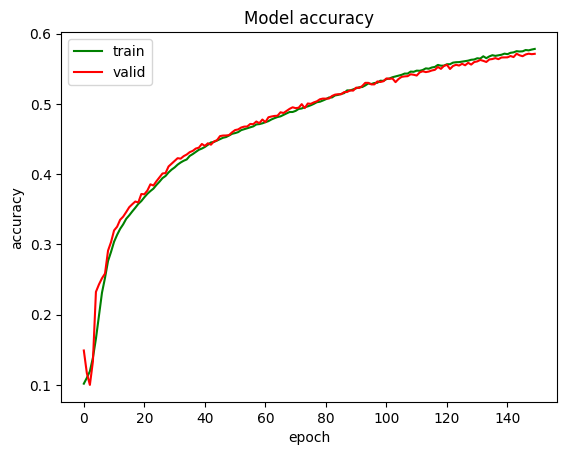

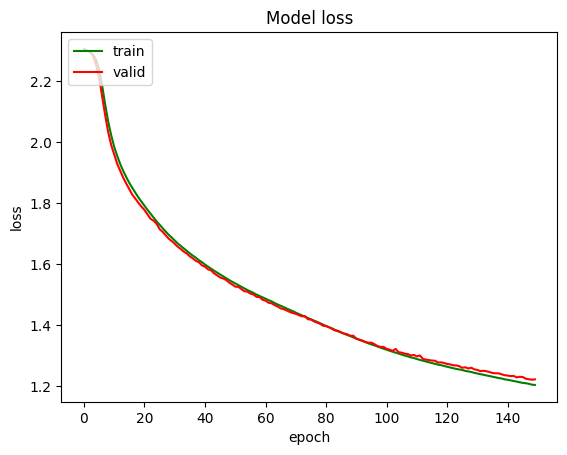

In [36]:
print_history(history.history)

Czas trenowania wzrósł nieznacznie, jedynie mniej więcej 3 sekundy na każdej epoce, w sumie ok. 400 sekund.  
Rezultaty wzrosły o prawie 10 punktów procentowych.  
Jestem zdziwony że tak drastyczna zmiana liczby parametrów (ok 7 razy więcej), tak nieznacznie wpłynęła na czas trwania epoki.


In [137]:
def block(channels, activation='relu', input_shape=None, batch_normalisation=False, dropout=None, gap=False):
    if input_shape:
        conv1 = tf.keras.layers.Conv2D(channels, 3, padding='same', activation=activation, input_shape=input_shape)
    else:
        conv1 = tf.keras.layers.Conv2D(channels, 3, padding='same', activation=activation)
    conv2 = tf.keras.layers.Conv2D(channels, 3, padding='same', activation=activation)
    if batch_normalisation:
        batch_norm1 = tf.keras.layers.BatchNormalization()
        batch_norm2 = tf.keras.layers.BatchNormalization()
    if dropout:
        drops = tf.keras.layers.Dropout(dropout)
    if gap:
        pool = tf.keras.layers.GlobalAveragePooling2D(data_format='channels_last', keepdims=False)
    else:
        pool = tf.keras.layers.MaxPool2D(pool_size=(2,2), padding='valid')
        
    if dropout:
        return [conv1, batch_norm1, conv2, batch_norm2, pool, drops]
    elif batch_normalisation:
        return [conv1, batch_norm1, conv2, batch_norm2, pool]
    else:
        return [conv1, conv2, pool]


Przygotowałem funkcję którą przygotowuje nam taki blok, zwraca go jako listę, więc mogę go dodać do innego bloku, bądź listy innych warst i tf.keras.Sequential nie będzie mieć problemów z formatem

In [58]:
model1 = tf.keras.Sequential(
    block(channels=20, activation='sigmoid', input_shape=train_images[0].shape) +
    block(channels=40, activation='sigmoid') + [
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=10,activation='softmax')
])

In [59]:
model1.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_31 (Conv2D)          (None, 32, 32, 20)        560       
                                                                 
 conv2d_32 (Conv2D)          (None, 32, 32, 20)        3620      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 16, 16, 20)       0         
 g2D)                                                            
                                                                 
 conv2d_33 (Conv2D)          (None, 16, 16, 40)        7240      
                                                                 
 conv2d_34 (Conv2D)          (None, 16, 16, 40)        14440     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 8, 8, 40)         0         
 g2D)                                                 

In [60]:
model1.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

In [61]:
history1 = model1.fit(
    x=train_images,
    y=train_labels,
    batch_size=64,
    epochs=15,
    verbose=1,
    validation_data=(val_images, val_labels)
)

Epoch 1/15


2022-10-27 17:02:56.479463: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


782/782 [==============================] - ETA: 0s - loss: 2.3263 - accuracy: 0.0988

2022-10-27 17:03:06.321068: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


782/782 [==============================] - 11s 13ms/step - loss: 2.3263 - accuracy: 0.0988 - val_loss: 2.3235 - val_accuracy: 0.1000
Epoch 2/15
782/782 [==============================] - 9s 12ms/step - loss: 2.3207 - accuracy: 0.1001 - val_loss: 2.3315 - val_accuracy: 0.1000
Epoch 3/15
782/782 [==============================] - 10s 13ms/step - loss: 2.3157 - accuracy: 0.1010 - val_loss: 2.3152 - val_accuracy: 0.1000
Epoch 4/15
782/782 [==============================] - 10s 12ms/step - loss: 2.3130 - accuracy: 0.0996 - val_loss: 2.3067 - val_accuracy: 0.1000
Epoch 5/15
782/782 [==============================] - 10s 12ms/step - loss: 2.3097 - accuracy: 0.1021 - val_loss: 2.3042 - val_accuracy: 0.1000
Epoch 6/15
782/782 [==============================] - 9s 12ms/step - loss: 2.3084 - accuracy: 0.1012 - val_loss: 2.3053 - val_accuracy: 0.1000
Epoch 7/15
782/782 [==============================] - 9s 12ms/step - loss: 2.3074 - accuracy: 0.1002 - val_loss: 2.3120 - val_accuracy: 0.1000
Epoch 

Wygląda to bardzo nieobiecująco, loss i accuracy praktycznie pozostały takie same...

In [65]:
model2 = tf.keras.Sequential(
    block(channels=20, activation='relu', input_shape=train_images[0].shape) +
    block(channels=40, activation='relu') + [
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=10,activation='softmax')
])

In [66]:
model2.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_39 (Conv2D)          (None, 32, 32, 20)        560       
                                                                 
 conv2d_40 (Conv2D)          (None, 32, 32, 20)        3620      
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 16, 16, 20)       0         
 g2D)                                                            
                                                                 
 conv2d_41 (Conv2D)          (None, 16, 16, 40)        7240      
                                                                 
 conv2d_42 (Conv2D)          (None, 16, 16, 40)        14440     
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 8, 8, 40)         0         
 g2D)                                                

In [67]:
model2.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

In [68]:
start_time = time.time()
hisotry2 = model2.fit(
    x=train_images,
    y=train_labels,
    batch_size=64,
    epochs=150,
    verbose=1,
    validation_data=(val_images, val_labels)
)
print(f"time: {time.time()-start_time}")

Epoch 1/150


2022-10-27 17:13:46.260185: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


782/782 [==============================] - ETA: 0s - loss: 2.1764 - accuracy: 0.1938

2022-10-27 17:13:55.343189: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


782/782 [==============================] - 10s 13ms/step - loss: 2.1764 - accuracy: 0.1938 - val_loss: 1.9325 - val_accuracy: 0.3098
Epoch 2/150
782/782 [==============================] - 10s 13ms/step - loss: 1.7968 - accuracy: 0.3655 - val_loss: 1.6535 - val_accuracy: 0.4148
Epoch 3/150
782/782 [==============================] - 10s 12ms/step - loss: 1.5625 - accuracy: 0.4446 - val_loss: 1.4597 - val_accuracy: 0.4846
Epoch 4/150
782/782 [==============================] - 10s 12ms/step - loss: 1.4455 - accuracy: 0.4854 - val_loss: 1.4012 - val_accuracy: 0.5023
Epoch 5/150
782/782 [==============================] - 9s 12ms/step - loss: 1.3731 - accuracy: 0.5122 - val_loss: 1.3722 - val_accuracy: 0.5125
Epoch 6/150
782/782 [==============================] - 9s 12ms/step - loss: 1.3032 - accuracy: 0.5382 - val_loss: 1.2813 - val_accuracy: 0.5449
Epoch 7/150
782/782 [==============================] - 10s 12ms/step - loss: 1.2455 - accuracy: 0.5638 - val_loss: 1.2332 - val_accuracy: 0.5619

Model liczył się bardzo szybko, szybciej nawet niż nasz pierwotny model, który jest dużo prostszy i ma o wiele mniej parametrów.  
Możemy zauważyć, że accuracy jest bardzo wysokie, a loss bardzo niski, ale niestety tylko dla zbioru treningowego, zbiór walidacyjny ma lepsze wyniki niż poprzednie modele (jeśli chodzi o accuracy, jeśli chodzi o loss, to jest on dużo wyższy niż początkowy), ale bardzo mocno odstające od zbioru treningowego, co sugeruje overfitting.

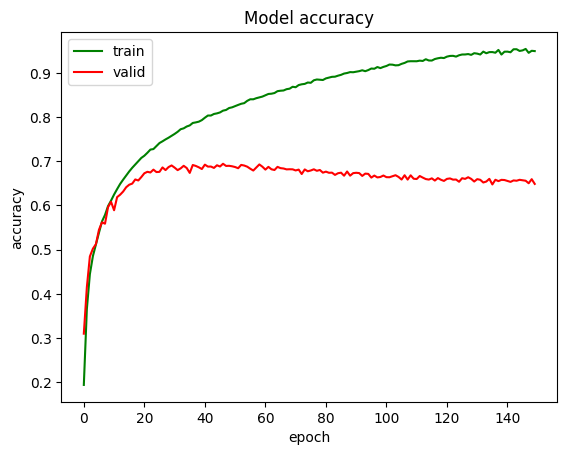

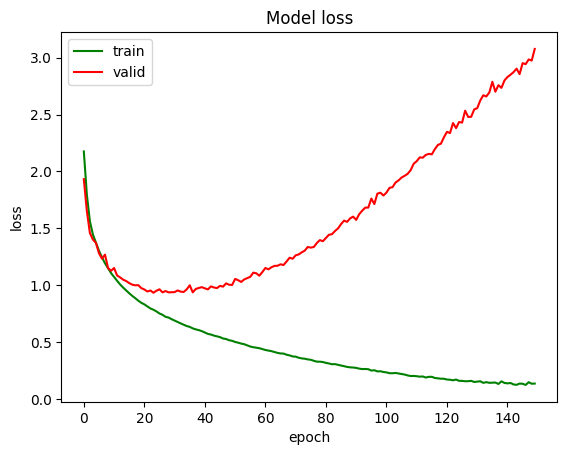

In [70]:
print_history(hisotry2.history)

In [99]:
model3 = tf.keras.Sequential(
    block(channels=20, activation='relu', input_shape=train_images[0].shape) +
    block(channels=40, activation='relu') + 
    block(channels=80, activation='relu') + 
    block(channels=160, activation='relu') + [
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=10,activation='softmax')
])

In [100]:
model3.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_91 (Conv2D)          (None, 32, 32, 20)        560       
                                                                 
 conv2d_92 (Conv2D)          (None, 32, 32, 20)        3620      
                                                                 
 max_pooling2d_45 (MaxPoolin  (None, 16, 16, 20)       0         
 g2D)                                                            
                                                                 
 conv2d_93 (Conv2D)          (None, 16, 16, 40)        7240      
                                                                 
 conv2d_94 (Conv2D)          (None, 16, 16, 40)        14440     
                                                                 
 max_pooling2d_46 (MaxPoolin  (None, 8, 8, 40)         0         
 g2D)                                                

In [101]:
model3.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

In [102]:
start_time = time.time()
hisotry3 = model3.fit(
    x=train_images,
    y=train_labels,
    batch_size=64,
    epochs=150,
    verbose=1,
    validation_data=(val_images, val_labels)
)
print(f"time: {time.time()-start_time}")

Epoch 1/150


2022-10-27 20:10:25.753797: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


782/782 [==============================] - ETA: 0s - loss: 2.2530 - accuracy: 0.1568

2022-10-27 20:10:38.747768: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


782/782 [==============================] - 14s 17ms/step - loss: 2.2530 - accuracy: 0.1568 - val_loss: 2.0130 - val_accuracy: 0.2606
Epoch 2/150
782/782 [==============================] - 13s 17ms/step - loss: 1.9138 - accuracy: 0.3023 - val_loss: 1.7708 - val_accuracy: 0.3632
Epoch 3/150
782/782 [==============================] - 13s 17ms/step - loss: 1.6901 - accuracy: 0.3857 - val_loss: 1.7128 - val_accuracy: 0.3930
Epoch 4/150
782/782 [==============================] - 13s 17ms/step - loss: 1.5419 - accuracy: 0.4435 - val_loss: 1.4859 - val_accuracy: 0.4646
Epoch 5/150
782/782 [==============================] - 13s 17ms/step - loss: 1.4403 - accuracy: 0.4821 - val_loss: 1.4032 - val_accuracy: 0.4954
Epoch 6/150
782/782 [==============================] - 13s 16ms/step - loss: 1.3609 - accuracy: 0.5137 - val_loss: 1.3121 - val_accuracy: 0.5320
Epoch 7/150
782/782 [==============================] - 13s 17ms/step - loss: 1.2796 - accuracy: 0.5440 - val_loss: 1.2709 - val_accuracy: 0.54

Tym razem model liczył się odrobinę wolniej od poprzedniego modelu, dalej jestem zaskoczony, że tak duża różnica w rozmiarach modelu liczy się tak niewiele wolniej.  
Mamy bardzo typowy przykład overfittingu, na danych treningowych model działa wyśmienicie, ale na walidacyjnych radzi sobie znacznie gorzej(choć wciąż lepiej od poprzednich modeli). Co ciekawe, wartość loss jest większa niż startowa, dla danych walidacyjnych. Nasz model nauczył się wszystkich zdjęć ze zbioru treningowego na pamięć.

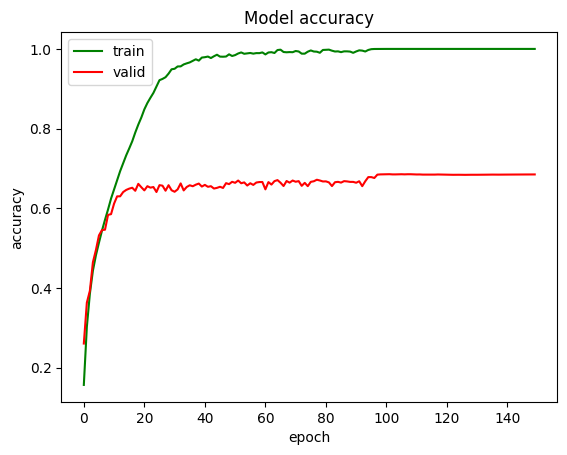

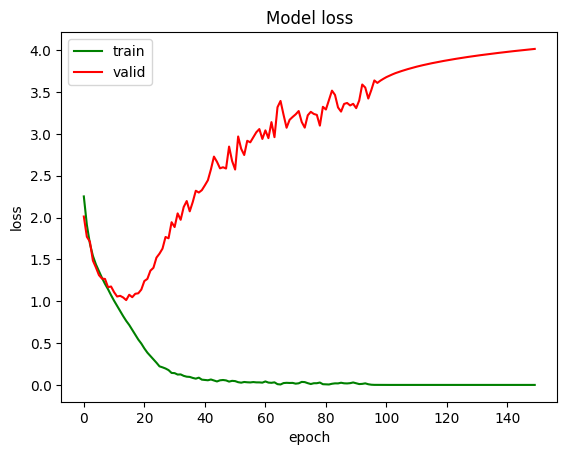

In [104]:
print_history(hisotry3.history)

# Batch norm

Dodałem batch normalization dzięki funkcji batchnormalization, z kerasa.  
Dodałem te warstwy normalizujące po każdej warstwie konwolucyjnej, zgodnie z poleceniem.

In [106]:
model = tf.keras.Sequential(
    block(channels=20, activation='relu', input_shape=train_images[0].shape, batch_normalisation=True) +
    block(channels=40, activation='relu', batch_normalisation=True) + 
    block(channels=80, activation='relu', batch_normalisation=True) + 
    block(channels=160, activation='relu', batch_normalisation=True) + [
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=10,activation='softmax')
])

In [108]:
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_105 (Conv2D)         (None, 32, 32, 20)        560       
                                                                 
 batch_normalization_30 (Bat  (None, 32, 32, 20)       80        
 chNormalization)                                                
                                                                 
 conv2d_106 (Conv2D)         (None, 32, 32, 20)        3620      
                                                                 
 batch_normalization_31 (Bat  (None, 32, 32, 20)       80        
 chNormalization)                                                
                                                                 
 max_pooling2d_52 (MaxPoolin  (None, 16, 16, 20)       0         
 g2D)                                                            
                                                     

In [109]:
model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

In [110]:
start_time = time.time()
hisotry = model.fit(
    x=train_images,
    y=train_labels,
    batch_size=64,
    epochs=150,
    verbose=1,
    validation_data=(val_images, val_labels)
)
print(f"time: {time.time()-start_time}")

Epoch 1/150


2022-10-27 22:04:04.992124: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


782/782 [==============================] - ETA: 0s - loss: 1.5026 - accuracy: 0.4813

2022-10-27 22:04:20.253288: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


782/782 [==============================] - 17s 21ms/step - loss: 1.5026 - accuracy: 0.4813 - val_loss: 1.4780 - val_accuracy: 0.4960
Epoch 2/150
782/782 [==============================] - 16s 20ms/step - loss: 1.0254 - accuracy: 0.6400 - val_loss: 1.2252 - val_accuracy: 0.5861
Epoch 3/150
782/782 [==============================] - 16s 20ms/step - loss: 0.8234 - accuracy: 0.7124 - val_loss: 0.9440 - val_accuracy: 0.6751
Epoch 4/150
782/782 [==============================] - 17s 22ms/step - loss: 0.6751 - accuracy: 0.7665 - val_loss: 0.8876 - val_accuracy: 0.6969
Epoch 5/150
782/782 [==============================] - 16s 20ms/step - loss: 0.5589 - accuracy: 0.8056 - val_loss: 0.9135 - val_accuracy: 0.6931
Epoch 6/150
782/782 [==============================] - 16s 20ms/step - loss: 0.4569 - accuracy: 0.8430 - val_loss: 0.8722 - val_accuracy: 0.7106
Epoch 7/150
782/782 [==============================] - 15s 20ms/step - loss: 0.3600 - accuracy: 0.8783 - val_loss: 0.9563 - val_accuracy: 0.69

Tym razem niewiele zwiększyliśmy rozmiar modelu (szczególnie pod względem liczby parametrów, szczególnie pod względem liczby parametrów do uczenia), tymczasem czas trawania uczenia wzrósł około o tyle samo co poprzednim razem.  
Dalej napotykamy ten sam problem - overfitting. Nasz model praktycznie doskonale zapamiętał zbiór treningowy, lecz nie daje aż takiej dobrej rady ze zbiorem walidacyjnym.  
Model daje sobie radę nieznacznie lepiej niż poprzednia wersja bez normalizacji batchy. 

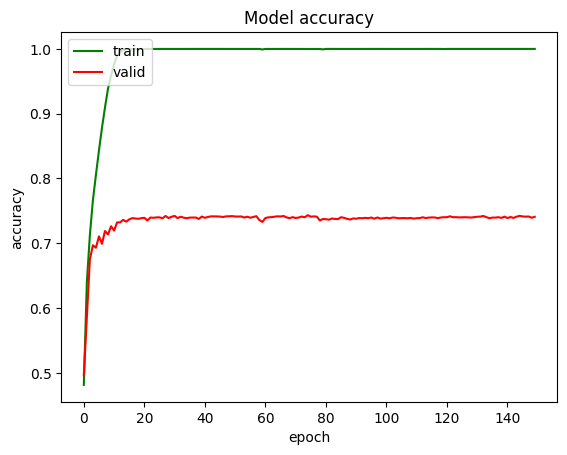

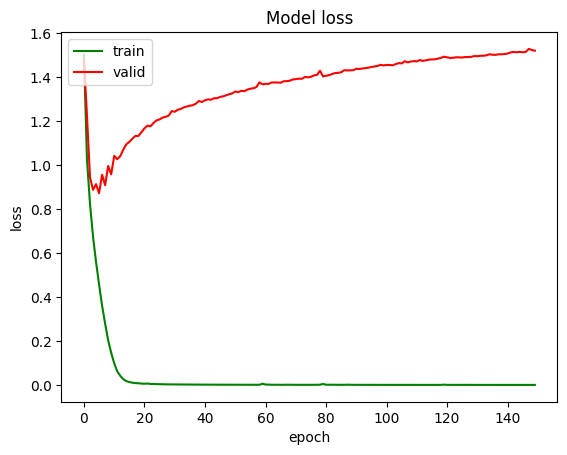

In [112]:
print_history(hisotry.history)

# DROPOUT

In [113]:
model = tf.keras.Sequential(
    block(channels=20, activation='relu', input_shape=train_images[0].shape, batch_normalisation=True, dropout=0.1) +
    block(channels=40, activation='relu', batch_normalisation=True, dropout=0.2) + 
    block(channels=80, activation='relu', batch_normalisation=True, dropout=0.3) + 
    block(channels=160, activation='relu', batch_normalisation=True, dropout=0.4) + [
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=10,activation='softmax')
])

In [114]:
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_113 (Conv2D)         (None, 32, 32, 20)        560       
                                                                 
 batch_normalization_38 (Bat  (None, 32, 32, 20)       80        
 chNormalization)                                                
                                                                 
 conv2d_114 (Conv2D)         (None, 32, 32, 20)        3620      
                                                                 
 batch_normalization_39 (Bat  (None, 32, 32, 20)       80        
 chNormalization)                                                
                                                                 
 max_pooling2d_56 (MaxPoolin  (None, 16, 16, 20)       0         
 g2D)                                                            
                                                     

In [115]:
model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

In [116]:
start_time = time.time()
history = model.fit(
    x=train_images,
    y=train_labels,
    batch_size=64,
    epochs=150,
    verbose=1,
    validation_data=(val_images, val_labels)
)
print(f"time: {time.time()-start_time}")

Epoch 1/150


2022-10-27 22:44:48.449655: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


782/782 [==============================] - ETA: 0s - loss: 1.8990 - accuracy: 0.3744

2022-10-27 22:45:04.592333: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


782/782 [==============================] - 19s 22ms/step - loss: 1.8990 - accuracy: 0.3744 - val_loss: 1.4651 - val_accuracy: 0.4627
Epoch 2/150
782/782 [==============================] - 16s 21ms/step - loss: 1.4158 - accuracy: 0.4985 - val_loss: 1.3939 - val_accuracy: 0.5429
Epoch 3/150
782/782 [==============================] - 16s 21ms/step - loss: 1.2437 - accuracy: 0.5579 - val_loss: 1.1554 - val_accuracy: 0.5926
Epoch 4/150
782/782 [==============================] - 16s 21ms/step - loss: 1.1185 - accuracy: 0.6037 - val_loss: 0.9758 - val_accuracy: 0.6532
Epoch 5/150
782/782 [==============================] - 16s 21ms/step - loss: 1.0304 - accuracy: 0.6367 - val_loss: 0.9476 - val_accuracy: 0.6678
Epoch 6/150
782/782 [==============================] - 16s 21ms/step - loss: 0.9492 - accuracy: 0.6636 - val_loss: 0.8802 - val_accuracy: 0.6922
Epoch 7/150
782/782 [==============================] - 16s 21ms/step - loss: 0.8946 - accuracy: 0.6835 - val_loss: 0.8773 - val_accuracy: 0.69

Tym razem, liczyło się niewiele dłużej co poprzednim razem (batch normalization).  
Model uczył się około 40 min.  
Widzimy, że tym razem model nie jest zbytnio przeuczony i daje rozsądne wyniki. 

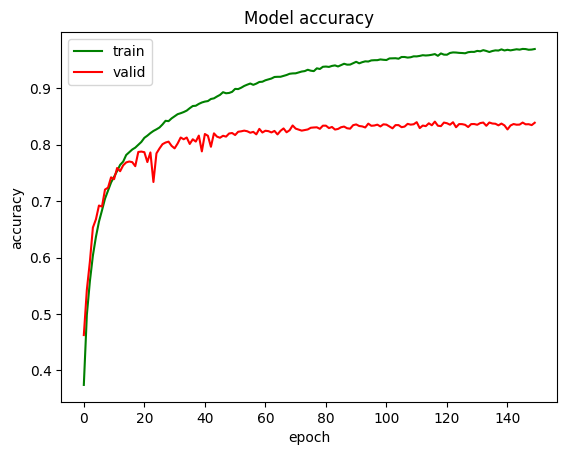

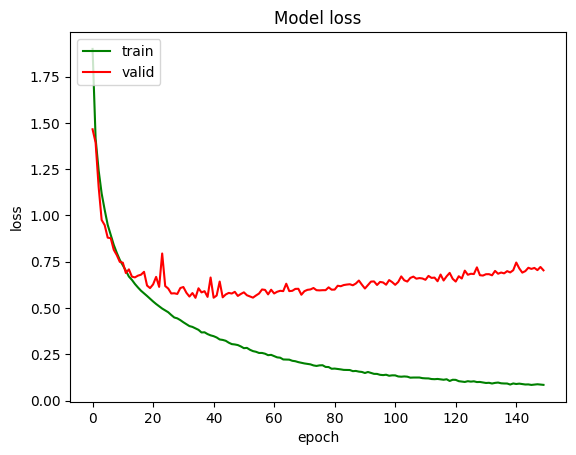

In [117]:
print_history(history.history)

# Mind the gap

In [144]:
model = tf.keras.Sequential(
    block(channels=20, activation='relu', input_shape=(None, None, 3), batch_normalisation=True, dropout=0.1) +
    block(channels=40, activation='relu', batch_normalisation=True, dropout=0.2) + 
    block(channels=80, activation='relu', batch_normalisation=True, dropout=0.3) + 
    block(channels=160, activation='relu', batch_normalisation=True, dropout=0.4, gap=True) + [
    tf.keras.layers.Dense(units=10,activation='softmax')
])

Ze względu na global average pooling, któremu ustawiłem keepdims na false, nie potrzebuję warstwy spłaszczającej, ponieważ warstwa GAP już to robi, zwłaszcza z parametrem keepdims=False.  
Dodatkowo ustawiłem input_shape na (None, None, 3), tak żeby sieć przyjmowała obrazy różnego rozmiaru na wejście.

In [145]:
model.summary()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_193 (Conv2D)         (None, None, None, 20)    560       
                                                                 
 batch_normalization_118 (Ba  (None, None, None, 20)   80        
 tchNormalization)                                               
                                                                 
 conv2d_194 (Conv2D)         (None, None, None, 20)    3620      
                                                                 
 batch_normalization_119 (Ba  (None, None, None, 20)   80        
 tchNormalization)                                               
                                                                 
 max_pooling2d_87 (MaxPoolin  (None, None, None, 20)   0         
 g2D)                                                            
                                                     

In [146]:
model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

In [147]:
start_time = time.time()
history = model.fit(
    x=train_images,
    y=train_labels,
    batch_size=64,
    epochs=150,
    verbose=1,
    validation_data=(val_images, val_labels)
)
print(f"time: {time.time()-start_time}")

Epoch 1/150


2022-10-28 01:01:37.073854: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


782/782 [==============================] - ETA: 0s - loss: 1.6360 - accuracy: 0.3979

2022-10-28 01:01:53.844152: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


782/782 [==============================] - 19s 23ms/step - loss: 1.6360 - accuracy: 0.3979 - val_loss: 1.6287 - val_accuracy: 0.4209
Epoch 2/150
782/782 [==============================] - 17s 22ms/step - loss: 1.2431 - accuracy: 0.5536 - val_loss: 1.1602 - val_accuracy: 0.5889
Epoch 3/150
782/782 [==============================] - 17s 22ms/step - loss: 1.1011 - accuracy: 0.6058 - val_loss: 1.1346 - val_accuracy: 0.6009
Epoch 4/150
782/782 [==============================] - 17s 22ms/step - loss: 1.0060 - accuracy: 0.6435 - val_loss: 0.9870 - val_accuracy: 0.6543
Epoch 5/150
782/782 [==============================] - 17s 22ms/step - loss: 0.9500 - accuracy: 0.6629 - val_loss: 0.9658 - val_accuracy: 0.6568
Epoch 6/150
782/782 [==============================] - 17s 22ms/step - loss: 0.8977 - accuracy: 0.6827 - val_loss: 0.8889 - val_accuracy: 0.6836
Epoch 7/150
782/782 [==============================] - 17s 22ms/step - loss: 0.8560 - accuracy: 0.6965 - val_loss: 0.8075 - val_accuracy: 0.71

Model znowu uczy się trochę dłużej, około 40 minut, ale nie aż tak dużo, biorąc pod uwagę zaawansowanie modelu.  
Nie zachodzi zjawisko overfittingu, a wyniki są zadawalające.

In [148]:
model.save_weights('./checkpoints/CIFAR')

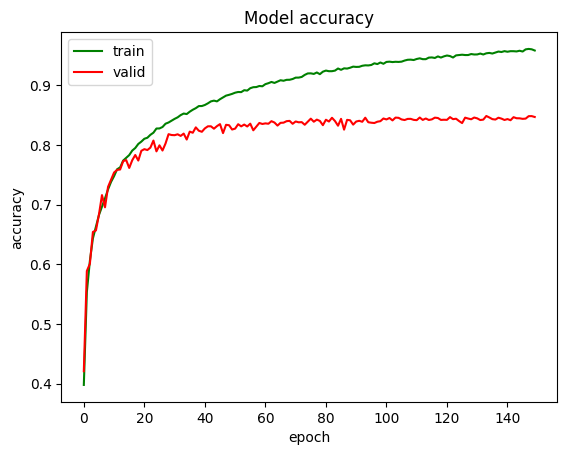

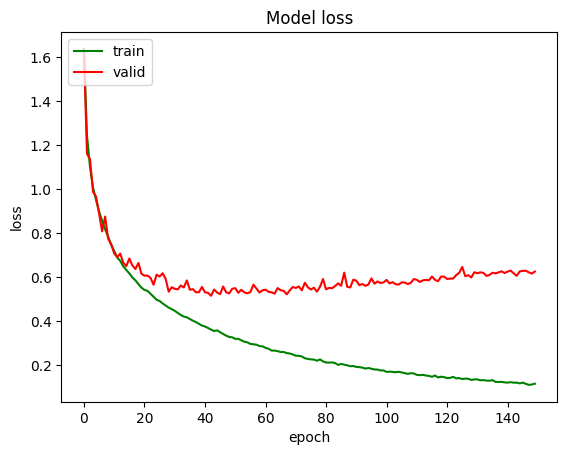

In [149]:
print_history(history.history)

# New Photo

In [150]:
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

(626, 417)


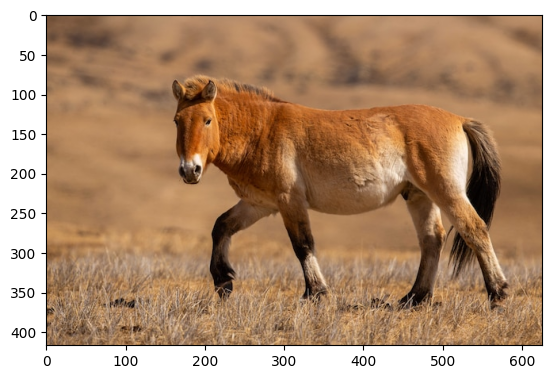

(536, 397)


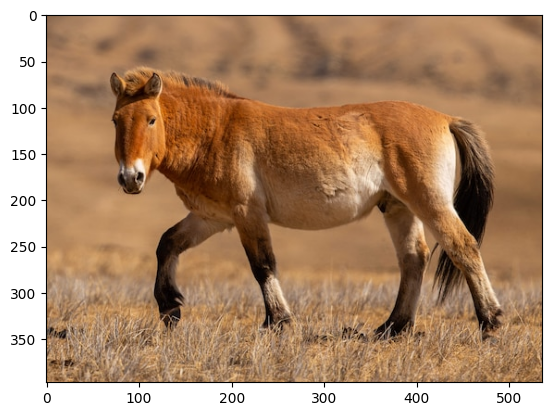

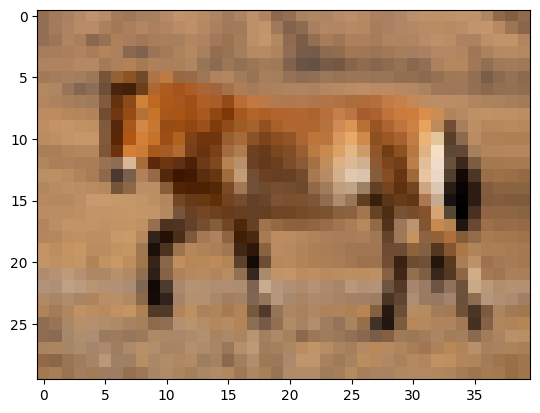

(40, 30)


In [216]:
url = 'https://img.freepik.com/free-photo/przewalskis-horse-portrait-magical-soft-light-during-winter-time-mongolia_475641-365.jpg'
im = Image.open(requests.get(url, stream=True).raw)
print(im.size)
plt.imshow(im)
plt.show()
img = im.crop((90,20,626,417))
print(img.size)
plt.imshow(img)
plt.show()
img.thumbnail((40,36))
plt.imshow(img)
plt.show()
print(img.size)

Proporcja jest bardzo niesymetryczna, więc trochę ucinam zbędnych boków, ale dalej zachowując ciekawszy kształt niż kwadrat.

In [217]:
img = tf.expand_dims(tf.keras.utils.img_to_array(img),axis=0)
img.shape

TensorShape([1, 30, 40, 3])

In [233]:
pred = np.ndarray.flatten(model.predict(img))
pred

1/1 [==============================] - 0s 16ms/step


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], dtype=float32)

In [234]:
classes = tf.convert_to_tensor(classes)
classes

<tf.Tensor: shape=(10,), dtype=string, numpy=
array([b'airplane', b'automobile', b'bird', b'cat', b'deer', b'dog',
       b'frog', b'horse', b'ship', b'truck'], dtype=object)>

In [236]:
classes[pred==1]

<tf.Tensor: shape=(1,), dtype=string, numpy=array([b'truck'], dtype=object)>

Jak widać, niestety sieć nie poradziła sobie z niekwadratowym zdjęciem konia.

Na podstawie tego zadania, zrozumiałem jak łatwo przetrenować sieć i jak można poprawić działanie sieci.  
Niestety mimo dosyć skomplikowanej architektury i sporego czasu liczenia, nie udało się uzyskać bardzo dobrego wyniku accuracy dla danych nietreningowych.